# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 3 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = (0.5-np.abs(0.5-prob))*dist
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


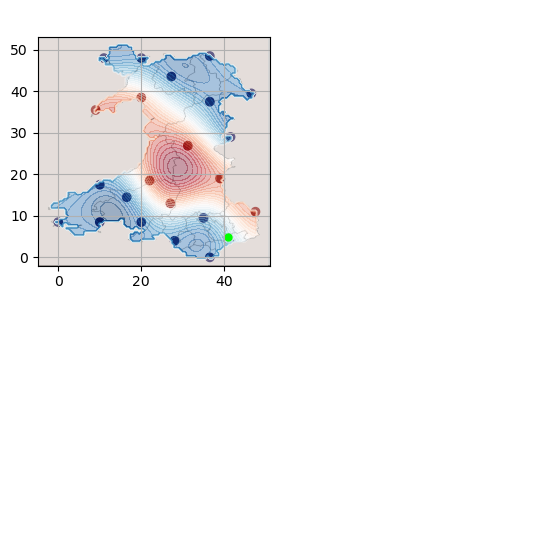

iteration  1
Accuracy is 0.5779657758123438
iteration  2
Accuracy is 0.7071716977504326
iteration  3
Accuracy is 0.6542972505287444
iteration  4
Accuracy is 0.6458373389732743
iteration  5
Accuracy is 0.7390886368006153
iteration  6
Accuracy is 0.7471640069217458
iteration  7
Accuracy is 0.7600461449721208
iteration  8
Accuracy is 0.7692751393962699
iteration  9
Accuracy is 0.7783118631032494
iteration  10
Accuracy is 0.8029225149009805
iteration  11
Accuracy is 0.8048452220726783
iteration  12
Accuracy is 0.8267640838300326
iteration  13
Accuracy is 0.7808113824264564
iteration  14
Accuracy is 0.7767736973658912
iteration  15
Accuracy is 0.7852336089213613
iteration  16
Accuracy is 0.7681215150932513
iteration  17
Accuracy is 0.7698519515477793
iteration  18
Accuracy is 0.817919630840223
iteration  19
Accuracy is 0.84618342626418
iteration  20
Accuracy is 0.8838684868294558
iteration  21
Accuracy is 0.8784849067487022
experiment:  1


<IPython.core.display.Javascript object>


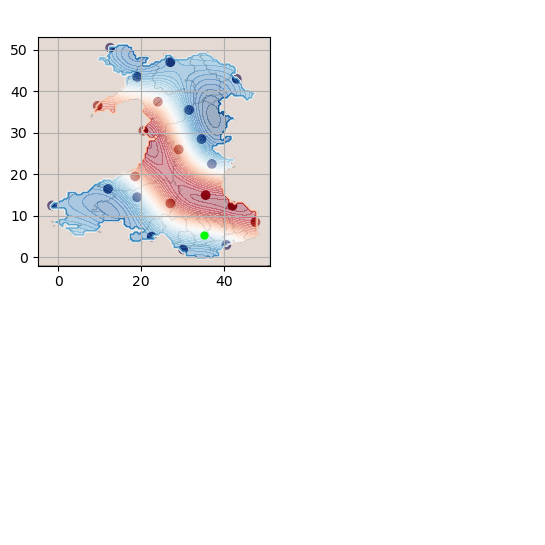

iteration  1
Accuracy is 0.505095174004999
iteration  2
Accuracy is 0.6366083445491252
iteration  3
Accuracy is 0.6318015766198808
iteration  4
Accuracy is 0.6308402230340319
iteration  5
Accuracy is 0.6308402230340319
iteration  6
Accuracy is 0.6169967313978081
iteration  7
Accuracy is 0.6150740242261103
iteration  8
Accuracy is 0.645260526821765
iteration  9
Accuracy is 0.637569698134974
iteration  10
Accuracy is 0.7125552778311863
iteration  11
Accuracy is 0.8388771390117286
iteration  12
Accuracy is 0.8169582772543742
iteration  13
Accuracy is 0.7875408575273986
iteration  14
Accuracy is 0.8269563545472025
iteration  15
Accuracy is 0.7929244376081522
iteration  16
Accuracy is 0.7842722553355124
iteration  17
Accuracy is 0.717169775043261
iteration  18
Accuracy is 0.8311863103249375
iteration  19
Accuracy is 0.8607960007690829
iteration  20
Accuracy is 0.8342626417996539
iteration  21
Accuracy is 0.8569505864256873
experiment:  2


<IPython.core.display.Javascript object>


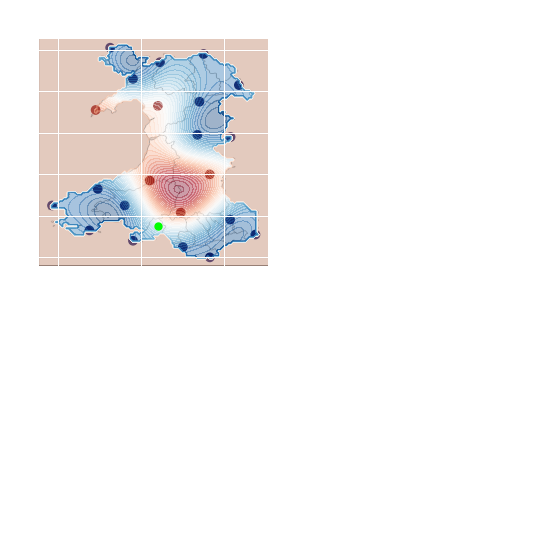

iteration  1
Accuracy is 0.4443376273793501
iteration  2
Accuracy is 0.7037108248413767
iteration  3
Accuracy is 0.6844837531243991
iteration  4
Accuracy is 0.6542972505287444
iteration  5
Accuracy is 0.6400692174581811
iteration  6
Accuracy is 0.7381272832147664
iteration  7
Accuracy is 0.7460103826187272
iteration  8
Accuracy is 0.7602384156892905
iteration  9
Accuracy is 0.7233224379926937
iteration  10
Accuracy is 0.7506248798308017
iteration  11
Accuracy is 0.7781195923860796
iteration  12
Accuracy is 0.7998461834262642
iteration  13
Accuracy is 0.8227263987694674
iteration  14
Accuracy is 0.8283022495673908
iteration  15
Accuracy is 0.832532205345126
iteration  16
Accuracy is 0.832532205345126
iteration  17
Accuracy is 0.888098442607191
iteration  18
Accuracy is 0.8465679676985195
iteration  19
Accuracy is 0.8417611997692751
iteration  20
Accuracy is 0.8177273601230532
iteration  21
Accuracy is 0.7821572774466449
experiment:  3


<IPython.core.display.Javascript object>


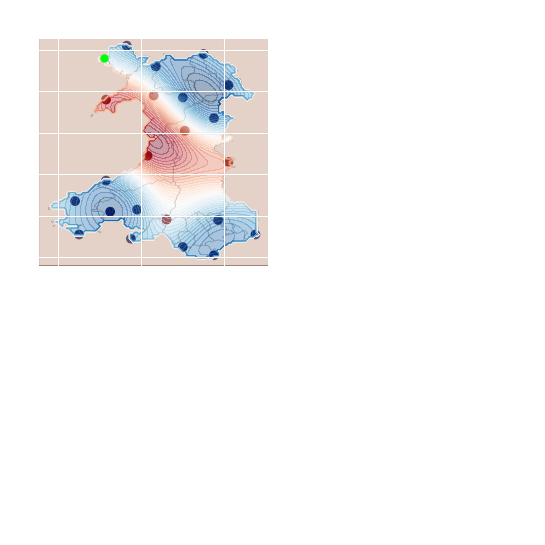

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.6544895212459142
iteration  3
Accuracy is 0.660642184195347
iteration  4
Accuracy is 0.6423764660642184
iteration  5
Accuracy is 0.6383387810036532
iteration  6
Accuracy is 0.6614112670640262
iteration  7
Accuracy is 0.685445106710248
iteration  8
Accuracy is 0.6858296481445876
iteration  9
Accuracy is 0.7083253220534512
iteration  10
Accuracy is 0.7331282445683522
iteration  11
Accuracy is 0.7885022111132475
iteration  12
Accuracy is 0.8279177081330513
iteration  13
Accuracy is 0.8184964429917324
iteration  14
Accuracy is 0.8177273601230532
iteration  15
Accuracy is 0.8206114208805999
iteration  16
Accuracy is 0.8023457027494713
iteration  17
Accuracy is 0.842722553355124
iteration  18
Accuracy is 0.8363776196885214
iteration  19
Accuracy is 0.8115746971736204
iteration  20
Accuracy is 0.830801768890598
iteration  21
Accuracy is 0.7904249182849452
experiment:  4


<IPython.core.display.Javascript object>


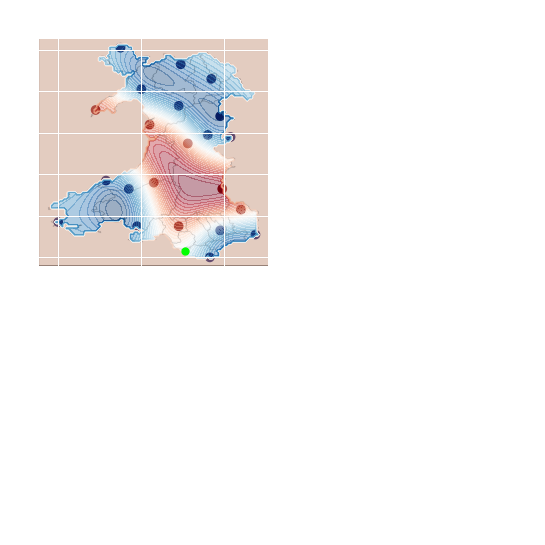

iteration  1
Accuracy is 0.6198807921553547
iteration  2
Accuracy is 0.7164006921745818
iteration  3
Accuracy is 0.6548740626802538
iteration  4
Accuracy is 0.6437223610844068
iteration  5
Accuracy is 0.6958277254374159
iteration  6
Accuracy is 0.6723706979427033
iteration  7
Accuracy is 0.6654489521245914
iteration  8
Accuracy is 0.7438954047298596
iteration  9
Accuracy is 0.7258219573159008
iteration  10
Accuracy is 0.7142857142857143
iteration  11
Accuracy is 0.8021534320323015
iteration  12
Accuracy is 0.7856181503557008
iteration  13
Accuracy is 0.8127283214766391
iteration  14
Accuracy is 0.8115746971736204
iteration  15
Accuracy is 0.8229186694866372
iteration  16
Accuracy is 0.8506056527590848
iteration  17
Accuracy is 0.8590655643145549
iteration  18
Accuracy is 0.8611805422034224
iteration  19
Accuracy is 0.8425302826379543
iteration  20
Accuracy is 0.8454143433955008
iteration  21
Accuracy is 0.8411843876177658
experiment:  5


<IPython.core.display.Javascript object>


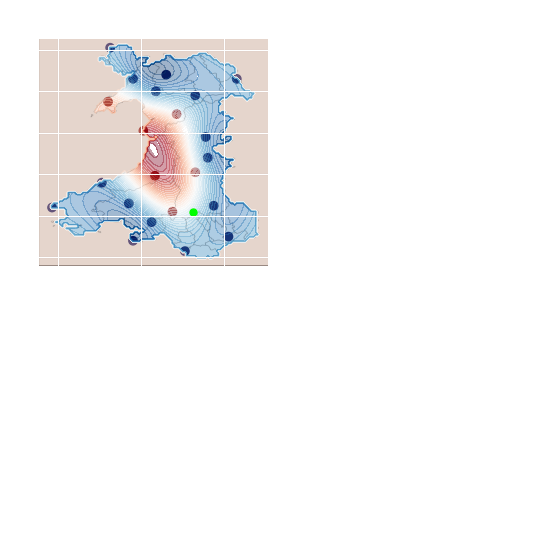

iteration  1
Accuracy is 0.40626802537973467
iteration  2
Accuracy is 0.7135166314170351
iteration  3
Accuracy is 0.6885214381849645
iteration  4
Accuracy is 0.6758315708517593
iteration  5
Accuracy is 0.6648721399730821
iteration  6
Accuracy is 0.7665833493558931
iteration  7
Accuracy is 0.7535089405883484
iteration  8
Accuracy is 0.7187079407806191
iteration  9
Accuracy is 0.7135166314170351
iteration  10
Accuracy is 0.7450490290328783
iteration  11
Accuracy is 0.7331282445683522
iteration  12
Accuracy is 0.798308017688906
iteration  13
Accuracy is 0.7858104210728706
iteration  14
Accuracy is 0.8165737358200346
iteration  15
Accuracy is 0.8634877908094597
iteration  16
Accuracy is 0.8557969621226688
iteration  17
Accuracy is 0.8525283599307826
iteration  18
Accuracy is 0.845222072678331
iteration  19
Accuracy is 0.8209959623149394
iteration  20
Accuracy is 0.8034993270524899
iteration  21
Accuracy is 0.7802345702749471
experiment:  6


<IPython.core.display.Javascript object>


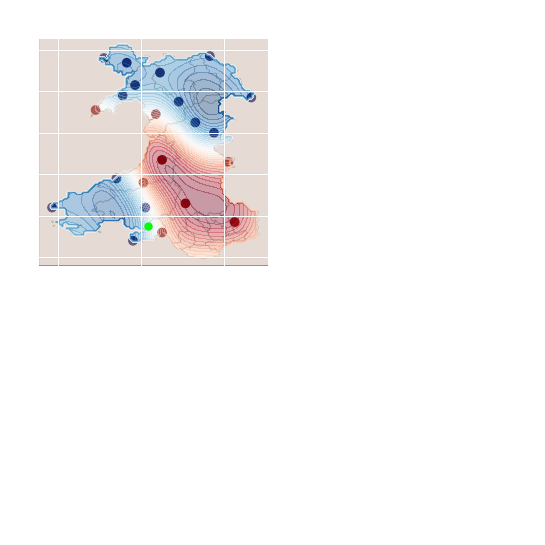

iteration  1
Accuracy is 0.5696981349740434
iteration  2
Accuracy is 0.7210151893866564
iteration  3
Accuracy is 0.6992885983464718
iteration  4
Accuracy is 0.6804460680638339
iteration  5
Accuracy is 0.7077485099019419
iteration  6
Accuracy is 0.6912132282253413
iteration  7
Accuracy is 0.6675639300134589
iteration  8
Accuracy is 0.6539127090944049
iteration  9
Accuracy is 0.6767929244376082
iteration  10
Accuracy is 0.7544702941741973
iteration  11
Accuracy is 0.7646606421841954
iteration  12
Accuracy is 0.7661988079215536
iteration  13
Accuracy is 0.8150355700826765
iteration  14
Accuracy is 0.788886752547587
iteration  15
Accuracy is 0.8013843491636223
iteration  16
Accuracy is 0.7823495481638146
iteration  17
Accuracy is 0.7746587194770237
iteration  18
Accuracy is 0.8034993270524899
iteration  19
Accuracy is 0.8084983656989041
iteration  20
Accuracy is 0.805998846375697
iteration  21
Accuracy is 0.7967698519515478
experiment:  7


<IPython.core.display.Javascript object>


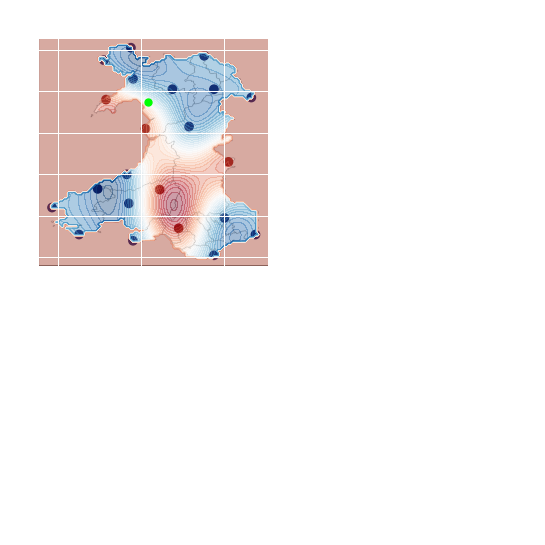

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.7533166698711786
iteration  3
Accuracy is 0.7135166314170351
iteration  4
Accuracy is 0.6902518746394924
iteration  5
Accuracy is 0.7279369352047683
iteration  6
Accuracy is 0.7187079407806191
iteration  7
Accuracy is 0.7575466256489136
iteration  8
Accuracy is 0.7610074985579697
iteration  9
Accuracy is 0.7631224764468372
iteration  10
Accuracy is 0.7835031724668333
iteration  11
Accuracy is 0.7642761007498557
iteration  12
Accuracy is 0.7538934820226879
iteration  13
Accuracy is 0.8002307248606038
iteration  14
Accuracy is 0.788886752547587
iteration  15
Accuracy is 0.8288790617189002
iteration  16
Accuracy is 0.8319553931936167
iteration  17
Accuracy is 0.8334935589309748
iteration  18
Accuracy is 0.8050374927898482
iteration  19
Accuracy is 0.7981157469717362
iteration  20
Accuracy is 0.7819650067294751
iteration  21
Accuracy is 0.7256296865987311
experiment:  8


<IPython.core.display.Javascript object>


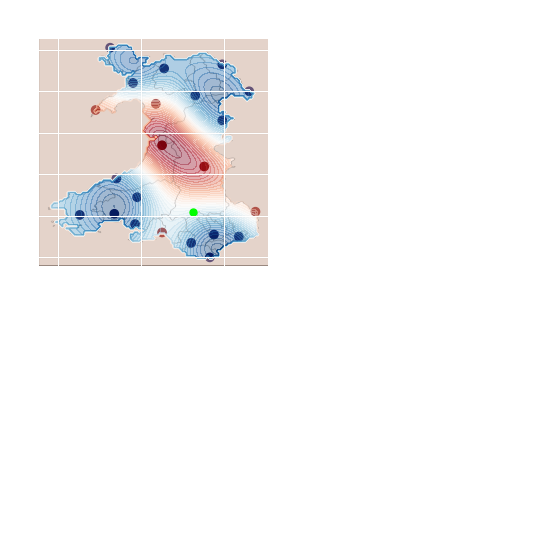

iteration  1
Accuracy is 0.5514324168429148
iteration  2
Accuracy is 0.7035185541242068
iteration  3
Accuracy is 0.6704479907710056
iteration  4
Accuracy is 0.6525668140742165
iteration  5
Accuracy is 0.6381465102864834
iteration  6
Accuracy is 0.7690828686791001
iteration  7
Accuracy is 0.7994616419919246
iteration  8
Accuracy is 0.7931167083253221
iteration  9
Accuracy is 0.8096519900019227
iteration  10
Accuracy is 0.8296481445875793
iteration  11
Accuracy is 0.8473370505671987
iteration  12
Accuracy is 0.8569505864256873
iteration  13
Accuracy is 0.8796385310517209
iteration  14
Accuracy is 0.8738704095366275
iteration  15
Accuracy is 0.8586810228802153
iteration  16
Accuracy is 0.8786771774658719
iteration  17
Accuracy is 0.8588732935973851
iteration  18
Accuracy is 0.8238800230724861
iteration  19
Accuracy is 0.8177273601230532
iteration  20
Accuracy is 0.8140742164968275
iteration  21
Accuracy is 0.800807537012113
experiment:  9


<IPython.core.display.Javascript object>


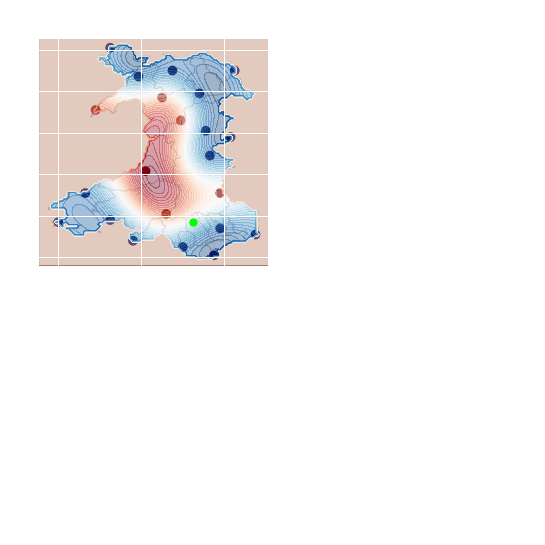

iteration  1
Accuracy is 0.5945010574889444
iteration  2
Accuracy is 0.7142857142857143
iteration  3
Accuracy is 0.6719861565083638
iteration  4
Accuracy is 0.6591040184579888
iteration  5
Accuracy is 0.6506441069025187
iteration  6
Accuracy is 0.7165929628917516
iteration  7
Accuracy is 0.7200538358008075
iteration  8
Accuracy is 0.7256296865987311
iteration  9
Accuracy is 0.7317823495481638
iteration  10
Accuracy is 0.7525475870024996
iteration  11
Accuracy is 0.7642761007498557
iteration  12
Accuracy is 0.7844645260526821
iteration  13
Accuracy is 0.8163814651028648
iteration  14
Accuracy is 0.8465679676985195
iteration  15
Accuracy is 0.8557969621226688
iteration  16
Accuracy is 0.8669486637185156
iteration  17
Accuracy is 0.8592578350317247
iteration  18
Accuracy is 0.8594501057488945
iteration  19
Accuracy is 0.873485868102288
iteration  20
Accuracy is 0.8594501057488945
iteration  21
Accuracy is 0.8088829071332436
experiment:  10


<IPython.core.display.Javascript object>


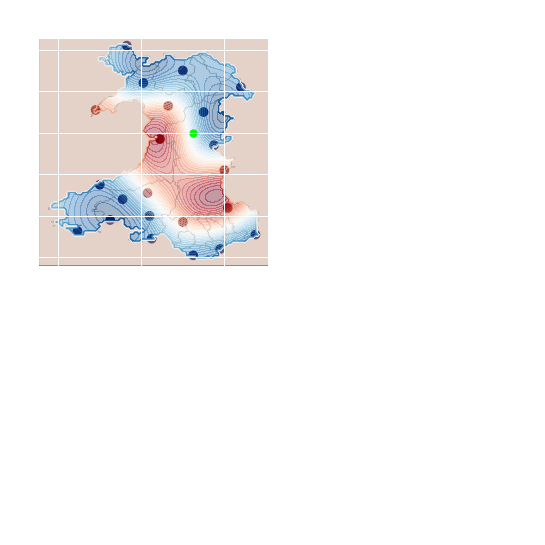

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.6294943280138435
iteration  3
Accuracy is 0.6156508363776196
iteration  4
Accuracy is 0.6131513170544126
iteration  5
Accuracy is 0.7754278023457027
iteration  6
Accuracy is 0.7548548356085368
iteration  7
Accuracy is 0.7919630840223034
iteration  8
Accuracy is 0.781195923860796
iteration  9
Accuracy is 0.744472216881369
iteration  10
Accuracy is 0.8238800230724861
iteration  11
Accuracy is 0.8131128629109786
iteration  12
Accuracy is 0.8309940396077677
iteration  13
Accuracy is 0.7856181503557008
iteration  14
Accuracy is 0.7836954431840031
iteration  15
Accuracy is 0.8215727744664487
iteration  16
Accuracy is 0.858104210728706
iteration  17
Accuracy is 0.8632955200922899
iteration  18
Accuracy is 0.8471447798500289
iteration  19
Accuracy is 0.8338781003653144
iteration  20
Accuracy is 0.8657950394154971
iteration  21
Accuracy is 0.8438761776581427
experiment:  11


<IPython.core.display.Javascript object>


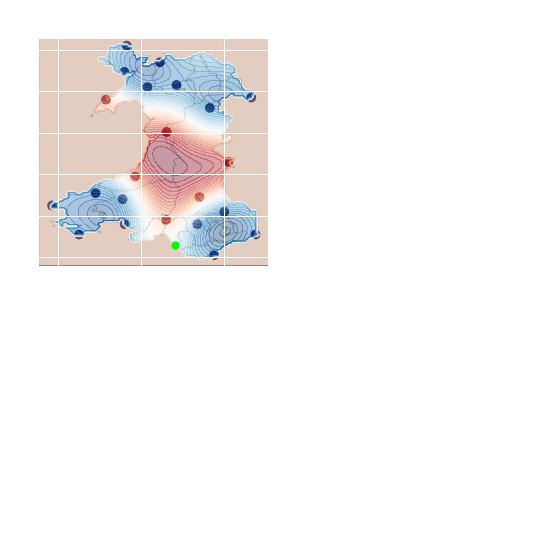

iteration  1
Accuracy is 0.48202268794462605
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.4676023841568929
iteration  4
Accuracy is 0.5308594501057489
iteration  5
Accuracy is 0.7327437031340127
iteration  6
Accuracy is 0.7365891174774082
iteration  7
Accuracy is 0.7037108248413767
iteration  8
Accuracy is 0.681215150932513
iteration  9
Accuracy is 0.8111901557392809
iteration  10
Accuracy is 0.8069601999615459
iteration  11
Accuracy is 0.7892712939819265
iteration  12
Accuracy is 0.8046529513555085
iteration  13
Accuracy is 0.8340703710824842
iteration  14
Accuracy is 0.845222072678331
iteration  15
Accuracy is 0.7973466641030571
iteration  16
Accuracy is 0.7413958854066526
iteration  17
Accuracy is 0.8375312439915401
iteration  18
Accuracy is 0.7875408575273986
iteration  19
Accuracy is 0.8402230340319169
iteration  20
Accuracy is 0.8446452605268218
iteration  21
Accuracy is 0.8406075754662565
experiment:  12


<IPython.core.display.Javascript object>


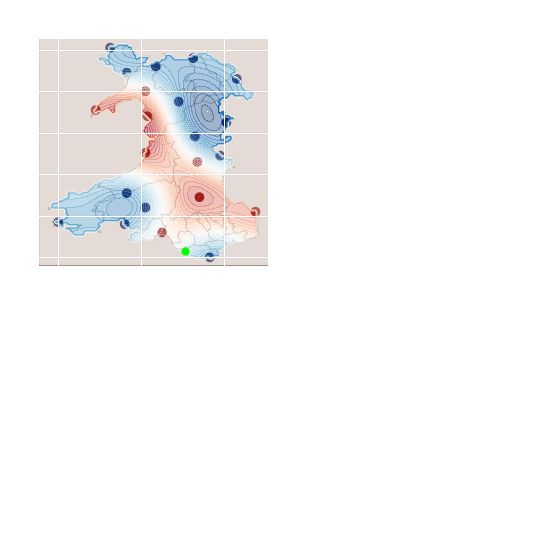

iteration  1
Accuracy is 0.5556623726206499
iteration  2
Accuracy is 0.6683330128821381
iteration  3
Accuracy is 0.6448759853874255
iteration  4
Accuracy is 0.6331474716400692
iteration  5
Accuracy is 0.6266102672562969
iteration  6
Accuracy is 0.6150740242261103
iteration  7
Accuracy is 0.6837146702557201
iteration  8
Accuracy is 0.6877523553162853
iteration  9
Accuracy is 0.6902518746394924
iteration  10
Accuracy is 0.7223610844068449
iteration  11
Accuracy is 0.7994616419919246
iteration  12
Accuracy is 0.8240722937896559
iteration  13
Accuracy is 0.8256104595270141
iteration  14
Accuracy is 0.8369544318400307
iteration  15
Accuracy is 0.8177273601230532
iteration  16
Accuracy is 0.8113824264564506
iteration  17
Accuracy is 0.817919630840223
iteration  18
Accuracy is 0.8144587579311671
iteration  19
Accuracy is 0.8306094981734282
iteration  20
Accuracy is 0.8542587963853105
iteration  21
Accuracy is 0.8394539511632378
experiment:  13


<IPython.core.display.Javascript object>


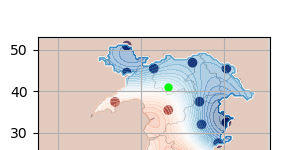

iteration  1
Accuracy is 0.5716208421457412
iteration  2
Accuracy is 0.6075754662564892
iteration  3
Accuracy is 0.6164199192462988
iteration  4
Accuracy is 0.6187271678523361
iteration  5
Accuracy is 0.742741780426841
iteration  6
Accuracy is 0.6956354547202461
iteration  7
Accuracy is 0.6583349355893098
iteration  8
Accuracy is 0.6531436262257259
iteration  9
Accuracy is 0.6500672947510094
iteration  10
Accuracy is 0.7167852336089213
iteration  11
Accuracy is 0.7590847913862718
iteration  12
Accuracy is 0.7517785041338204
iteration  13
Accuracy is 0.8006152662949433
iteration  14
Accuracy is 0.8233032109209767
iteration  15
Accuracy is 0.8352239953855027
iteration  16
Accuracy is 0.8463756969813497
iteration  17
Accuracy is 0.8373389732743703
iteration  18
Accuracy is 0.8450298019611613
iteration  19
Accuracy is 0.8284945202845606
iteration  20
Accuracy is 0.8140742164968275
iteration  21
Accuracy is 0.8077292828302249
experiment:  14


<IPython.core.display.Javascript object>


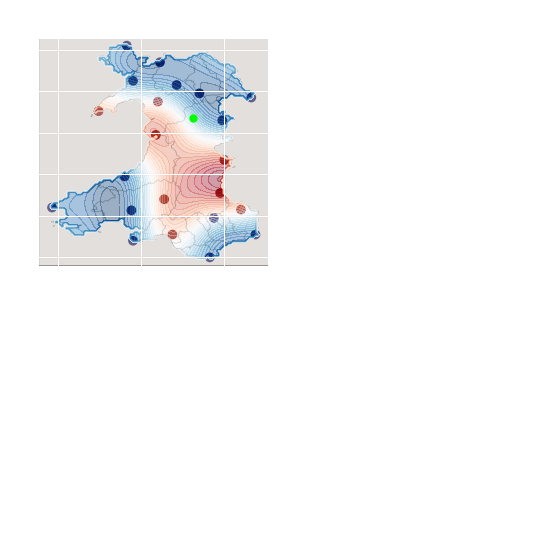

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.7635070178811767
iteration  4
Accuracy is 0.7394731782349548
iteration  5
Accuracy is 0.6500672947510094
iteration  6
Accuracy is 0.6287252451451644
iteration  7
Accuracy is 0.8421457412036147
iteration  8
Accuracy is 0.8108056143049414
iteration  9
Accuracy is 0.8373389732743703
iteration  10
Accuracy is 0.8248413766583349
iteration  11
Accuracy is 0.8267640838300326
iteration  12
Accuracy is 0.790617189002115
iteration  13
Accuracy is 0.8004229955777735
iteration  14
Accuracy is 0.7723514708709863
iteration  15
Accuracy is 0.7513939626994809
iteration  16
Accuracy is 0.7994616419919246
iteration  17
Accuracy is 0.8575273985771967
iteration  18
Accuracy is 0.8613728129205922
iteration  19
Accuracy is 0.886368006152663
iteration  20
Accuracy is 0.8802153432032301
iteration  21
Accuracy is 0.8736781388194578
experiment:  15


<IPython.core.display.Javascript object>


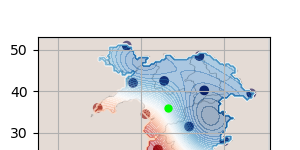

iteration  1
Accuracy is 0.6021918861757354
iteration  2
Accuracy is 0.7483176312247645
iteration  3
Accuracy is 0.6946741011343972
iteration  4
Accuracy is 0.7415881561238223
iteration  5
Accuracy is 0.7540857527398577
iteration  6
Accuracy is 0.7292828302249568
iteration  7
Accuracy is 0.7089021342049606
iteration  8
Accuracy is 0.6973658911747741
iteration  9
Accuracy is 0.836762161122861
iteration  10
Accuracy is 0.835031724668333
iteration  11
Accuracy is 0.8248413766583349
iteration  12
Accuracy is 0.7985002884060758
iteration  13
Accuracy is 0.7704287636992886
iteration  14
Accuracy is 0.7244760622957124
iteration  15
Accuracy is 0.7521630455681599
iteration  16
Accuracy is 0.8002307248606038
iteration  17
Accuracy is 0.817919630840223
iteration  18
Accuracy is 0.8306094981734282
iteration  19
Accuracy is 0.8215727744664487
iteration  20
Accuracy is 0.8519515477792732
iteration  21
Accuracy is 0.8506056527590848
experiment:  16


<IPython.core.display.Javascript object>


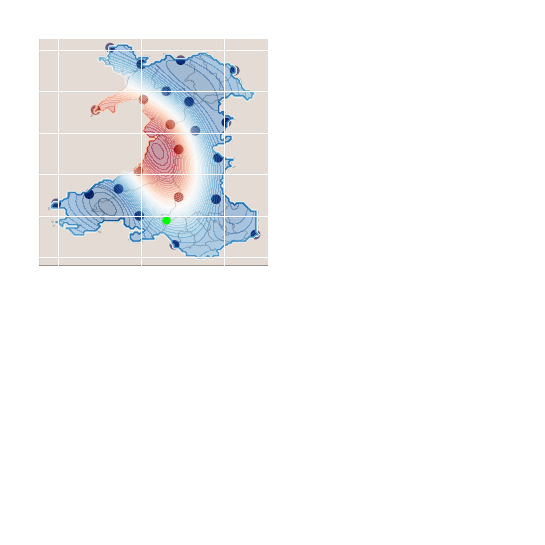

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.7031340126898673
iteration  3
Accuracy is 0.6533358969428956
iteration  4
Accuracy is 0.6417996539127091
iteration  5
Accuracy is 0.6348779080945972
iteration  6
Accuracy is 0.7633147471640069
iteration  7
Accuracy is 0.7556239184772159
iteration  8
Accuracy is 0.7246683330128821
iteration  9
Accuracy is 0.7229378965583542
iteration  10
Accuracy is 0.7567775427802346
iteration  11
Accuracy is 0.7767736973658912
iteration  12
Accuracy is 0.7723514708709863
iteration  13
Accuracy is 0.7650451836185349
iteration  14
Accuracy is 0.8009998077292828
iteration  15
Accuracy is 0.8083060949817343
iteration  16
Accuracy is 0.8108056143049414
iteration  17
Accuracy is 0.7940780619111709
iteration  18
Accuracy is 0.7711978465679677
iteration  19
Accuracy is 0.7661988079215536
iteration  20
Accuracy is 0.7450490290328783
iteration  21
Accuracy is 0.8013843491636223
experiment:  17


<IPython.core.display.Javascript object>


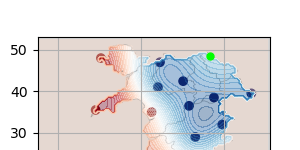

iteration  1
Accuracy is 0.49701980388386846
iteration  2
Accuracy is 0.5775812343780042
iteration  3
Accuracy is 0.591424726014228
iteration  4
Accuracy is 0.5989232839838493
iteration  5
Accuracy is 0.6990963276293021
iteration  6
Accuracy is 0.7375504710632571
iteration  7
Accuracy is 0.7396654489521246
iteration  8
Accuracy is 0.7304364545279753
iteration  9
Accuracy is 0.7342818688713709
iteration  10
Accuracy is 0.7338973274370313
iteration  11
Accuracy is 0.7875408575273986
iteration  12
Accuracy is 0.7554316477600461
iteration  13
Accuracy is 0.7796577581234378
iteration  14
Accuracy is 0.7775427802345702
iteration  15
Accuracy is 0.7963853105172082
iteration  16
Accuracy is 0.8194577965775812
iteration  17
Accuracy is 0.7977312055373966
iteration  18
Accuracy is 0.8036915977696597
iteration  19
Accuracy is 0.742741780426841
iteration  20
Accuracy is 0.7187079407806191
iteration  21
Accuracy is 0.7400499903864641
experiment:  18


<IPython.core.display.Javascript object>


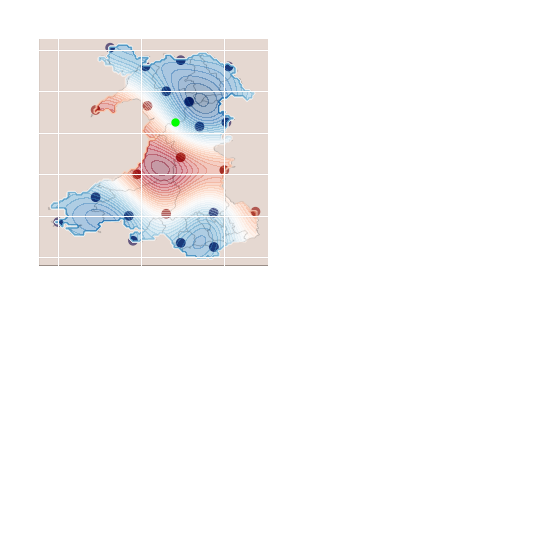

iteration  1
Accuracy is 0.39030955585464333
iteration  2
Accuracy is 0.7275523937704288
iteration  3
Accuracy is 0.6969813497404346
iteration  4
Accuracy is 0.6775620073062872
iteration  5
Accuracy is 0.6639107863872332
iteration  6
Accuracy is 0.7402422611036339
iteration  7
Accuracy is 0.7458181119015574
iteration  8
Accuracy is 0.7238992501442031
iteration  9
Accuracy is 0.7592770621034416
iteration  10
Accuracy is 0.788886752547587
iteration  11
Accuracy is 0.8027302441838108
iteration  12
Accuracy is 0.7927321668909825
iteration  13
Accuracy is 0.7979234762545664
iteration  14
Accuracy is 0.8359930782541819
iteration  15
Accuracy is 0.8448375312439915
iteration  16
Accuracy is 0.8465679676985195
iteration  17
Accuracy is 0.8294558738704095
iteration  18
Accuracy is 0.8623341665064411
iteration  19
Accuracy is 0.8648336858296481
iteration  20
Accuracy is 0.8636800615266295
iteration  21
Accuracy is 0.8381080561430494
experiment:  19


<IPython.core.display.Javascript object>


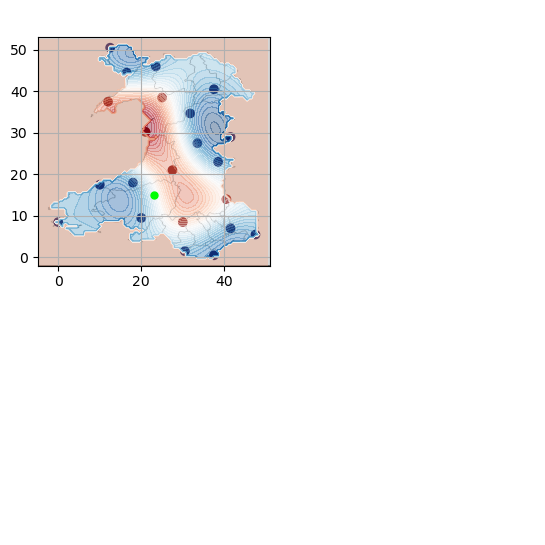

iteration  1
Accuracy is 0.5673908863680062
iteration  2
Accuracy is 0.6642953278215727
iteration  3
Accuracy is 0.6308402230340319
iteration  4
Accuracy is 0.6223803114785618
iteration  5
Accuracy is 0.6575658527206306
iteration  6
Accuracy is 0.6502595654681792
iteration  7
Accuracy is 0.6479523168621419
iteration  8
Accuracy is 0.7744664487598538
iteration  9
Accuracy is 0.8306094981734282
iteration  10
Accuracy is 0.827340895981542
iteration  11
Accuracy is 0.8242645645068256
iteration  12
Accuracy is 0.8206114208805999
iteration  13
Accuracy is 0.8413766583349356
iteration  14
Accuracy is 0.8323399346279562
iteration  15
Accuracy is 0.8077292828302249
iteration  16
Accuracy is 0.8302249567390886
iteration  17
Accuracy is 0.8338781003653144
iteration  18
Accuracy is 0.7931167083253221
iteration  19
Accuracy is 0.7771582388002307
iteration  20
Accuracy is 0.765814266487214
iteration  21
Accuracy is 0.7667756200730629
experiment:  20


<IPython.core.display.Javascript object>


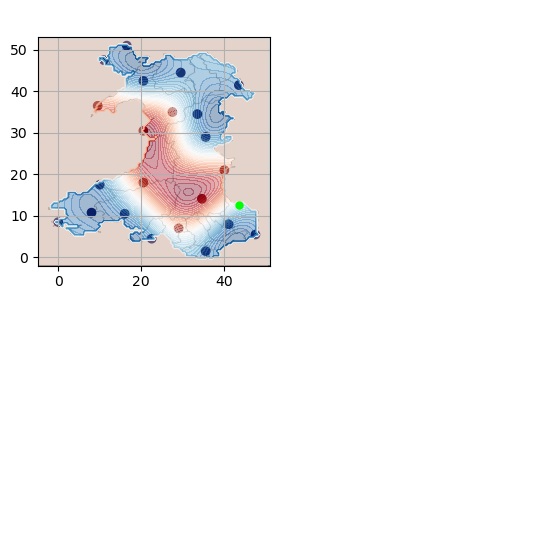

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.7117861949625072
iteration  3
Accuracy is 0.6714093443568544
iteration  4
Accuracy is 0.6537204383772351
iteration  5
Accuracy is 0.8348394539511632
iteration  6
Accuracy is 0.7879253989617381
iteration  7
Accuracy is 0.7271678523360892
iteration  8
Accuracy is 0.694866371851567
iteration  9
Accuracy is 0.6454527975389348
iteration  10
Accuracy is 0.775235531628533
iteration  11
Accuracy is 0.7992693712747548
iteration  12
Accuracy is 0.7986925591232455
iteration  13
Accuracy is 0.785425879638531
iteration  14
Accuracy is 0.8204191501634301
iteration  15
Accuracy is 0.8521438184964429
iteration  16
Accuracy is 0.8609882714862527
iteration  17
Accuracy is 0.8673332051528552
iteration  18
Accuracy is 0.8781003653143626
iteration  19
Accuracy is 0.8850221111324745
iteration  20
Accuracy is 0.8669486637185156
iteration  21
Accuracy is 0.8650259565468179


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 88.50 %
Improvement is = 31.96 %


In [10]:
np.savetxt('braninbestrbf', Results)